# Alex AI/ML Training V3

Testing approach from https://www.sciencedirect.com/science/article/pii/S0021929018304354
Estimation of vertical ground reaction force during running using neural network model and uniaxial accelerometer



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-12-02 09:57:38.821272: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 09:57:38.829988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733126258.839813 1698564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733126258.842925 1698564 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 09:57:38.853844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10850727900701366143
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1135214592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18387576982223966851
physical_device_desc: "device: 0, name: NVIDIA RTX 500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1733126260.157732 1698564 gpu_device.cc:2022] Created device /device:GPU:0 with 1082 MB memory:  -> device: 0, name: NVIDIA RTX 500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
#directory path
dir_path = "/home/alexbeat/data/kuopio-gait-dataset-ml"
input_path = f"{dir_path}/_main-input.csv"
output_path = f"{dir_path}/_main-output.csv"

In [4]:
x_og = pd.read_csv(input_path, index_col=0)  # 49 input features
y_og = pd.read_csv(output_path, index_col=0)   # 3 output features (x, y, z)

x_og.drop(columns=['time'], inplace=True)
y_og.drop(columns=['time'], inplace=True)


num_rows = 100000
x = x_og[:num_rows]
y = y_og[:num_rows]

In [5]:
print(x.head())

   pelvis_imu_acc_0  pelvis_imu_acc_1  pelvis_imu_acc_2  tibia_r_imu_acc_0  \
0          9.761505         -0.539103          1.818704          12.697140   
1         10.134969         -0.911804          1.594711          10.897347   
2         10.385214         -1.351347          1.155096           9.525765   
3         10.543116         -1.864298          0.684864           9.072569   
4         10.660259         -2.339200          0.291542           9.549234   

   tibia_r_imu_acc_1  tibia_r_imu_acc_2  femur_r_imu_acc_0  femur_r_imu_acc_1  \
0          16.125368           6.755737           6.553590          -9.642062   
1          16.414892           6.965524           7.794528          -8.131455   
2          14.627335           5.945245           8.543280          -7.183258   
3          11.909804           4.448972           8.545444          -6.877351   
4          10.364927           3.148921           7.764376          -6.626254   

   femur_r_imu_acc_2  tibia_l_imu_acc_0  ...

In [6]:
print(y_og.head())
print(y.head())

       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854
       f2_1      f2_2       f2_3
0 -0.678967  0.748046  -7.150059
1 -0.721937  1.238132  -9.194256
2 -0.582924  1.809044 -10.333972
3 -0.132954  2.361078  -9.370096
4  0.781994  2.707438  -4.607854


In [7]:
scalerX = StandardScaler()
X = scalerX.fit_transform(x)

# Y = y
scalerY = StandardScaler()
Y = scalerY.fit_transform(y)
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (100000, 49)
Y shape: (100000, 3)


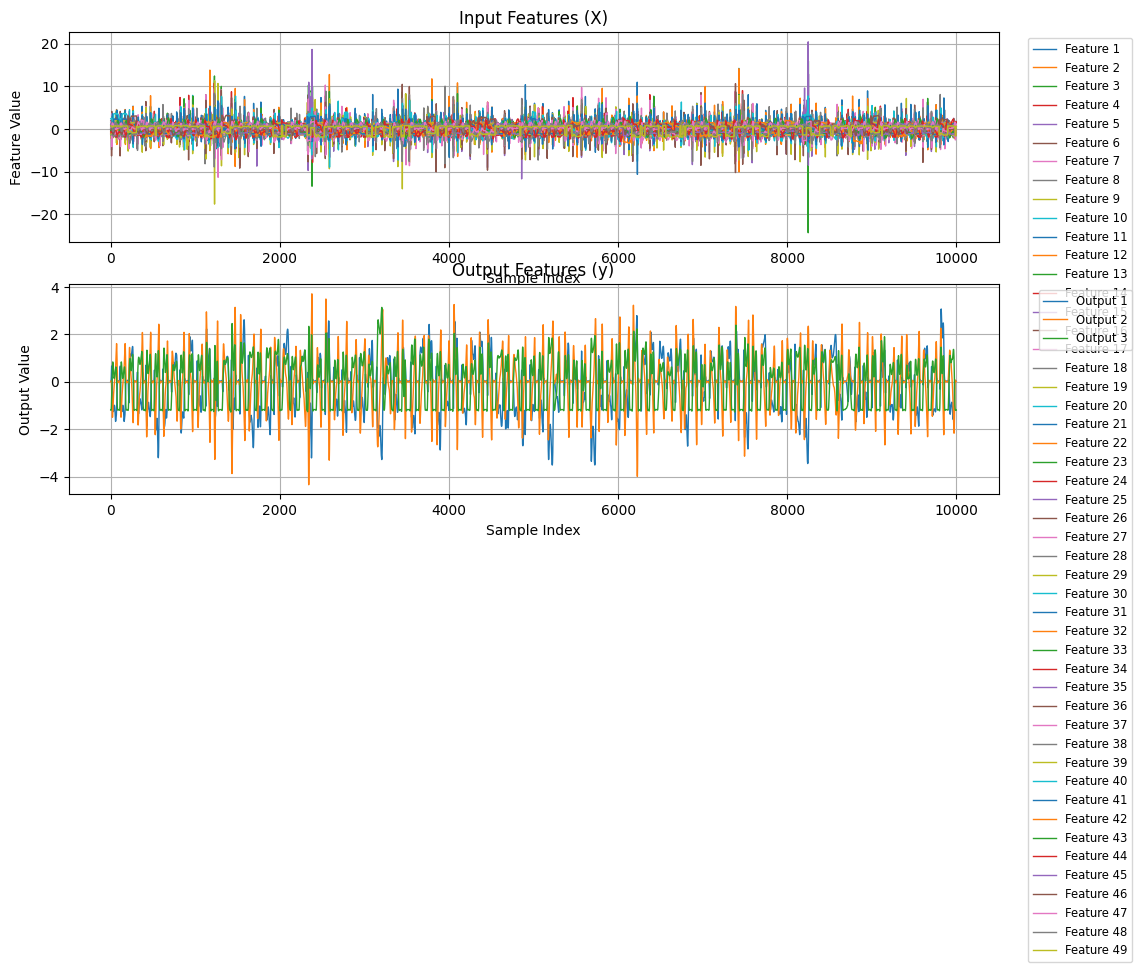

In [8]:
# Create a figure
plt.figure(figsize=(12, 6))

graph_window = 10000
# Plotting the input features (X)
plt.subplot(2, 1, 1)
for i in range(X.shape[1]):  # Loop through each feature (column)
    plt.plot(X[:graph_window, i], label=f'Feature {i+1}', linewidth=1)
plt.title('Input Features (X)')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

# Plotting the output features (y)
plt.subplot(2, 1, 2)
for i in range(Y.shape[1]):  # Loop through each output feature (column)
    plt.plot(Y[:graph_window, i], label=f'Output {i+1}', linewidth=1)
plt.title('Output Features (y)')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
plt.grid()

plt.show()

![nn-architecture.png](nn-architecture.png)

In [15]:
model = Sequential()

model.add(Input(shape=(49,)))  # Using Input layer

# Input layer and first hidden layer
model.add(Dense(128, activation='sigmoid'))

# Second hidden layer
model.add(Dense(256, activation='relu'))

# Output layer
model.add(Dense(3, activation='linear'))  # Linear activation for regression

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,195 (157.01 KB)

 Trainable params: 40,195 (157.01 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
model.fit(X, Y, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100


I0000 00:00:1733126311.535136 1698703 service.cc:148] XLA service 0x70fbe8004f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733126311.535156 1698703 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 500 Ada Generation Laptop GPU, Compute Capability 8.9
2024-12-02 09:58:31.546149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733126311.596979 1698703 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-02 09:58:32.418806: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_270', 448 bytes spill stores, 448 bytes spill loads

2024-12-02 09:58:32.516502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

 186/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.7321 - mae: 0.6610

I0000 00:00:1733126313.227353 1698703 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4272 - mae: 0.4638 - val_loss: 0.1825 - val_mae: 0.2866
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - loss: 0.2219 - mae: 0.3104 - val_loss: 0.1700 - val_mae: 0.2807
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - loss: 0.2001 - mae: 0.2933 - val_loss: 0.1570 - val_mae: 0.2691
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 0.1871 - mae: 0.2843 - val_loss: 0.1473 - val_mae: 0.2520
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - loss: 0.1727 - mae: 0.2728 - val_loss: 0.1443 - val_mae: 0.2584
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.1602 - mae: 0.2638 - val_loss: 0.1424 - val_mae: 0.2497
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.1517 - mae: 0.2568 - val_loss: 0.1301 - val_mae: 0.2380
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 0.1421 - mae: 0.2488 - val_loss: 0.1317 - val_mae: 0.2410
Epoch 9/100
1250/1250 ━━━━━━━━

In [18]:
x_text_path = f"{dir_path}/input/01-l_comf_01-input.csv"
y_text_path = f"{dir_path}/output/01-l_comf_01-output.csv"
X_test = pd.read_csv(x_text_path, index_col=0)  # 49 input features
y_test = pd.read_csv(y_text_path, index_col=0)   # 3 output features (x, y, z)
X_test.drop(columns=['time'], inplace=True)
y_test.drop(columns=['time'], inplace=True)

# Normalize test data
X_test = scalerX.transform(X_test)
y_test = scalerY.transform(y_test)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5957 - mae: 0.9776
Test Loss: 1.199774146080017, Test MAE: 0.7861526012420654


In [19]:
predictions = model.predict(X_test)
print(predictions)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[[-1.6179782   0.26294872  0.8957803 ]
 [-1.6224025   0.25822183  0.88914585]
 [-1.6246469   0.26333758  0.8950814 ]
 ...
 [-1.1206696   0.08593939  0.39085642]
 [-1.1351601   0.08795072  0.3977134 ]
 [-1.1526221   0.0877637   0.4092838 ]]


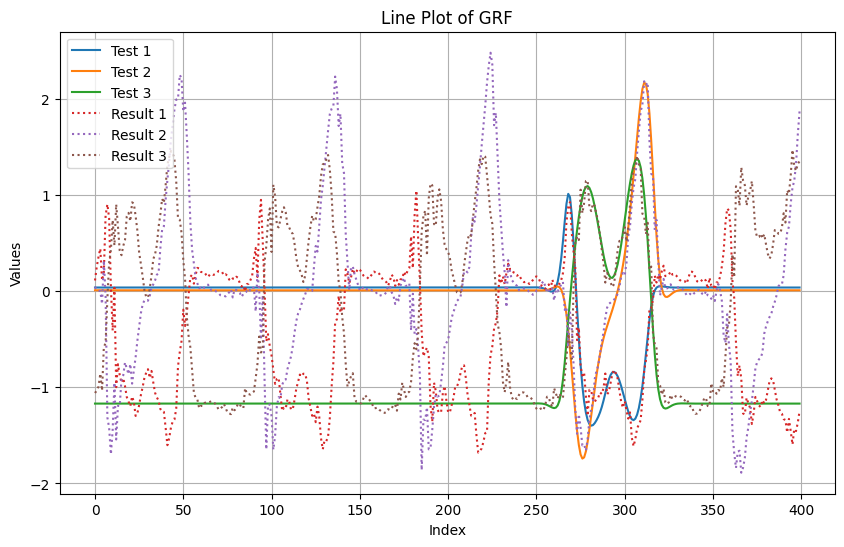

In [20]:
# Plotting the DataFrame
plt.figure(figsize=(10, 6))

min_window = 300
max_window = 700

for i in range(y_test.shape[1]):  # Loop over the number of columns
    plt.plot(y_test[min_window:max_window, i], label=f'Test {i+1}')  # Use marker for visibility

# Plot each column as a separate line
for i in range(predictions.shape[1]):  # Loop over the number of columns
    plt.plot(predictions[min_window:max_window, i], label=f'Result {i+1}', linestyle=':')  # Use marker for visibility

# Adding titles and labels
plt.title('Line Plot of GRF')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
# plt.yscale('log')  # Optional: Use logarithmic scale for better visibility of small values
plt.show()

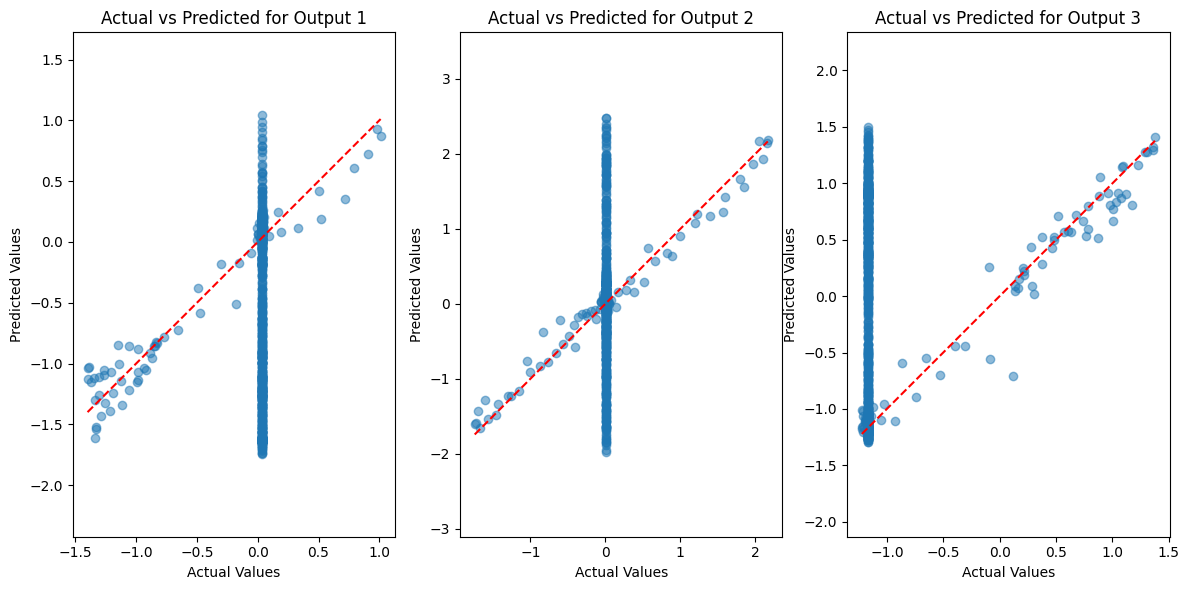

In [21]:
# Create a figure
plt.figure(figsize=(12, 6))
actual_values = y_test
predicted_values = predictions

# Plot actual vs predicted for each output (x, y, z)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(actual_values[:, i], predicted_values[:, i], alpha=0.5)
    plt.plot([actual_values[:, i].min(), actual_values[:, i].max()],
             [actual_values[:, i].min(), actual_values[:, i].max()], 'r--')  # Diagonal line
    plt.title(f'Actual vs Predicted for Output {i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.axis('equal')

plt.tight_layout()
plt.show()